<a href="https://colab.research.google.com/github/Khaled-Eldowa/CMST/blob/master/Toxic_Comments_ML_Final_Project_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beginning of Part 2

As we mentioned before, in this part we will send the data through two stages; one for binary classification, and the second for multi-label classifciation on the comments that were classified as not-clean in the first stage. Finally, we will combine the predictions and evaluate again.

In [0]:
import pandas as pd
import numpy as np

In [6]:
!pip install kaggle
!mkdir ~/.kaggle
!mkdir ./.kaggle
import json
token = {"username":"cyaniderxx","key":"24da407480fcb4682ad5b8f60addbd68"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
!kaggle datasets download -d yliu9999/glove6b50d

- path is now set to: {/content}
  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 92.1MB/s]
 38% 9.00M/23.4M [00:00<00:01, 13.7MB/s]
100% 23.4M/23.4M [00:00<00:00, 34.3MB/s]
 80% 21.0M/26.3M [00:00<00:00, 17.1MB/s]
100% 26.3M/26.3M [00:00<00:00, 31.9MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 97.6MB/s]
 68% 46.0M/67.7M [00:01<00:01, 18.8MB/s]
100% 67.7M/67.7M [00:01<00:00, 43.8MB/s]


In [12]:
!unzip ./{/content}/competitions/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
!unzip ./{/content}/competitions/jigsaw-toxic-comment-classification-challenge/test.csv.zip
!unzip ./{/content}/competitions/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
!unzip ./{/content}/competitions/jigsaw-toxic-comment-classification-challenge/train.csv.zip
!unzip ./{/content}/datasets/yliu9999/glove6b50d/glove6b50d.zip

Archive:  ./{/content}/competitions/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  ./{/content}/competitions/jigsaw-toxic-comment-classification-challenge/test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  ./{/content}/competitions/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip
replace test_labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  ./{/content}/competitions/jigsaw-toxic-comment-classification-challenge/train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  ./{/content}/datasets/yliu9999/glove6b50d/glove6b50d.zip
  inflating: glove.6B.50d.txt        


In [2]:
import sys, os, re, csv, codecs

from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D, Flatten
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


Here we read the dataset, split it, and tokenize it:

In [0]:
train = pd.read_csv('train.csv')

#https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)

In [0]:
list_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'none']

here the target is just one column (1 for clean, 0 for labelled)

In [0]:
X_train,X_test,y_train,y_test = train_test_split(train["comment_text"], train['none'],test_size=0.2,random_state=10)

In [0]:
import string
maxlen = 50
#list sentences from the dataset
list_sentences_train = X_train.fillna("_na_").values
list_sentences_test = X_test.fillna("_na_").values
y_t = y_train.values
y_te = y_test.values

tokenizer = Tokenizer(split = f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])', lower = True)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

For the first stage, we considered the use of three models: NB-SVM, NB-Logistic Regression, and LSTM. Here we test each one of them to see which one is the best:

# First Stage (NB-SVM)

Naive Bayes SVM was proposed as a good algorithm for sentiment analysis. We used the code from: https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline but we modified it to work with just one target variable (clean).

In [0]:
from sklearn.svm import SVC

In [0]:
def pr(y_i, y, x):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [0]:
def get_mdl(x,y):
    r = np.log(pr(1,y,x) / pr(0,y,x))
    m = SVC(verbose=True)
    x_nb = x * r
    return m.fit(x_nb, y), r

In [32]:
m,r = get_mdl(X_t, y_t)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[LibSVM]

In [0]:
preds = m.predict(X_te * r)

In [42]:
accuracy_score(y_te, preds)

0.8998590004699984

The accuracy is not bad, but it is deceptive. As we discussed in part 1, the vast majority (about 93%) of the comments are clean (not-labelled), so it might be the case that the algorithm is just classifying almost everything as clean. Let's check the confusion matrix:

In [0]:
from sklearn.metrics import confusion_matrix as cm

In [44]:
cm(y_te, preds)

array([[   42,  3139],
       [   57, 28677]])

We can see that almost all the negatives (not-clean) are classified as positive (top rigth). This doesn't only refute the significance of the accuracy score, it would have left us with almost no tuples for the next stage!

# First Stage (Logistic Regression)

Let's try the same algorithm but with logisitc regression instead of SVM. Here we used C=8, which was obtained after several trials.

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
def get_mdl2(x,y):
    r = np.log(pr(1,y,x) / pr(0,y,x))
    m = LogisticRegression(C=8)
    x_nb = x * r
    return m.fit(x_nb, y), r

In [66]:
m2, r2 = get_mdl2(X_t, y_t)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
preds2 = m2.predict(X_te * r2)

In [68]:
accuracy_score(y_te, preds2)

0.8978850070499765

Similar score, let's see the confusion matrix:

In [69]:
cm(y_te, preds2)

array([[    1,  3180],
       [   79, 28655]])

Again almost all labelled comments are being lost and classified as clean. Thus, we have to resort to an actual LSTM to do this binary classification.

# First stage (LSTM)

We will use an LSTM to do the clean/not-clean classification. We will read and split the data set again as to include all columns needed by the forthcoming models.

In [0]:
train = pd.read_csv('train.csv')

here we add clean and also not clean for the classifier (we only used one target (clean) in the previous two models)

In [0]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['clean'] = 1-train[label_cols].max(axis=1)
train.loc[train.clean == 1, 'not_clean'] = int(0)
train.loc[train.clean !=1, 'not_clean'] = int(1)
train['not_clean'] =  train['not_clean'].astype('int64')

We will include all the columns in the split, and take subset when necessary.

In [0]:
X_train,X_test,y_train,y_test = train_test_split(train["comment_text"], train[["clean", "not_clean", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]],test_size=0.2,random_state=10)

prepare our dataset for tokenization. We only use clean and not-clean labels from the y_train and y_test.

In [0]:
list_sentences_train = X_train.fillna("_na_").values
list_sentences_test = X_test.fillna("_na_").values
list_classes = ["clean", "not_clean"]
y_t = y_train[list_classes].values
y_te = y_test[list_classes].values

We will use glove to vectorize our comments and produce an embedding matrix.

In [0]:
EMBEDDING_FILE='glove.6B.50d.txt'
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # 

In [0]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [0]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [14]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [0]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

Here we use softmax at the last layer since this is an ordinary classification (unlike the ones in part 1).

In [16]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(2, activation="softmax")(x)
model3 = Model(inputs=inp, outputs=x)
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
history3 = model3.fit(X_t, y_t, batch_size=40, epochs=2, validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 102124 samples, validate on 25532 samples
Epoch 1/2
102124/102124 [==============================] - 1365s 13ms/step - loss: 0.1315 - acc: 0.9523 - val_loss: 0.1046 - val_acc: 0.9612
Epoch 2/2
102124/102124 [==============================] - 1572s 15ms/step - loss: 0.0928 - acc: 0.9654 - val_loss: 0.1066 - val_acc: 0.9632


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


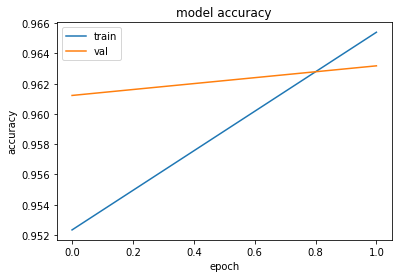

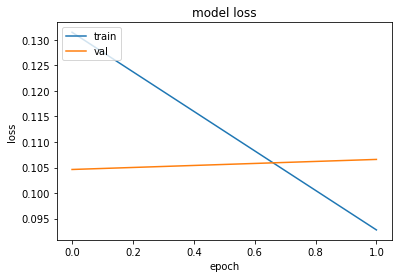

In [18]:
def show_graphs(history):
  # list all data in history
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

show_graphs(history3)

decent accuracy, but we shall not fall for that, we will also check the confusion matrix. But first let's see how the test set performs:

In [0]:
preds=model3.predict(X_te)

In [20]:
preds

array([[9.9506122e-01, 4.9387706e-03],
       [9.9987948e-01, 1.2053741e-04],
       [9.9982482e-01, 1.7519646e-04],
       ...,
       [9.9775463e-01, 2.2454243e-03],
       [9.9587727e-01, 4.1227508e-03],
       [6.3568127e-01, 3.6431870e-01]], dtype=float32)

We vectorize (one-hot) the predictions:

In [0]:
preds_new = np.zeros(shape=(preds.shape[0], preds.shape[1]))
for i in np.arange(preds.shape[0]):
  preds_new[i] = [1,0] if preds[i][0] > preds[i][1] else [0,1]

In [0]:
preds_new = preds_new.astype(int)

Here we can use accuracy_score (unlike in part 1)

In [24]:
accuracy_score(y_te, preds_new)

0.9648127839573868

Good, now for the confusion matrix:

In [25]:
cm(np.argmax(y_te, axis=1), np.argmax(preds, axis=1))

array([[28466,   268],
       [  855,  2326]])

**(note that this matrix is inverted compared to the previous two)**

We can see that the number of false positives (bottom left) is significantly lower than the previous two models. We shall go ahead and use this model,  but we have to keep mind that we are still losing about 25% of the labelled comments, but it' the best we can do for now. 




Using the hamming loss for calculating the accuracy is not needed here, but we shall do it anyway.

In [0]:
from sklearn.metrics import hamming_loss

In [27]:
1 - hamming_loss(y_te, preds_new)

0.9648127839573868

same as accuracy_score() (as expected)

# Second Stage

In this stage we filter in only the comments we have predicted to be not clean, and perform regression on those comments to fit them to the remaining labels. We do this so the model cannot get high accuracy by just fitting all (or most ) labels to 0, since most of the comments do not belong to any label (and hence are clean).

predict which comments are clean/not clean in the training set:

In [0]:
filtered = model3.predict(X_t)

vectorize (one-hot) the predictions:

In [0]:
filtered_vectorized = np.zeros(shape=(filtered.shape[0], filtered.shape[1]))
for i in np.arange(filtered.shape[0]):
  filtered_vectorized[i] = [1,0] if filtered[i][0] > filtered[i][1] else [0,1]

In [30]:
filtered_vectorized = filtered_vectorized.astype(int)
filtered_vectorized.shape

(127656, 2)

We create copies of the dataset (train and test), and later filter these copies of all the predicted-clean comments:

In [0]:
y_train2 = pd.DataFrame()
y_train2 = y_train.copy()
#add the predcitions as a column
y_train2['preds'] = filtered_vectorized[:,0]
X_train2 = pd.DataFrame()
X_train2 = X_train.copy()
X_train2 = X_train.to_frame()

We perform an inner join on the ids of the prediction made in the last stage and the original comments, so that all the comments and labels are correctly matched for training We do this for the test and train dataset we then check to make sure the inner join was correct

In [0]:
data_t2=pd.concat([y_train2.set_index(y_train2.index),
                  X_train2.set_index(X_train2.index)], axis=1)

In [34]:
train.loc[train.index==129567]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,not_clean
129567,b51ca8f632cf2acc,"Wikipedia has articles on the Bible, the Torah...",0,0,0,0,0,0,1,0


In [35]:
data_t2.loc[data_t2.index==129567]

,clean,not_clean,toxic,severe_toxic,obscene,threat,insult,identity_hate,preds,comment_text
129567,1,0,0,0,0,0,0,0,1,"Wikipedia has articles on the Bible, the Torah..."


In [36]:
data_t2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127656 entries, 55539 to 83209
Data columns (total 10 columns):
clean            127656 non-null int64
not_clean        127656 non-null int64
toxic            127656 non-null int64
severe_toxic     127656 non-null int64
obscene          127656 non-null int64
threat           127656 non-null int64
insult           127656 non-null int64
identity_hate    127656 non-null int64
preds            127656 non-null int64
comment_text     127656 non-null object
dtypes: int64(9), object(1)
memory usage: 10.7+ MB


filter the training data of the precited-clean comments:

In [0]:
data_t2_filtered = data_t2[data_t2.preds != 1]

In [38]:
data_t2_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10889 entries, 159411 to 51595
Data columns (total 10 columns):
clean            10889 non-null int64
not_clean        10889 non-null int64
toxic            10889 non-null int64
severe_toxic     10889 non-null int64
obscene          10889 non-null int64
threat           10889 non-null int64
insult           10889 non-null int64
identity_hate    10889 non-null int64
preds            10889 non-null int64
comment_text     10889 non-null object
dtypes: int64(9), object(1)
memory usage: 935.8+ KB


Do the same stuff on the test set:

In [0]:
y_test2 = pd.DataFrame()
y_test2 = y_test.copy()
y_test2['preds'] = preds_new[:,0]
X_test2 = pd.DataFrame()
X_test2 = X_test.copy()
X_test2 = X_test.to_frame()

In [0]:
data_te2=pd.concat([y_test2.set_index(y_test2.index),
                  X_test2.set_index(X_test2.index)], axis=1)

In [41]:
train.loc[train.index==53051]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,not_clean
53051,8dc6f6c9091fcc8b,He is bad man! He makes much vandalism! 177.15...,0,0,0,0,0,0,1,0


In [42]:
data_te2.loc[data_te2.index==53051]

,clean,not_clean,toxic,severe_toxic,obscene,threat,insult,identity_hate,preds,comment_text
53051,1,0,0,0,0,0,0,0,1,He is bad man! He makes much vandalism! 177.15...


In [43]:
data_te2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31915 entries, 33683 to 90865
Data columns (total 10 columns):
clean            31915 non-null int64
not_clean        31915 non-null int64
toxic            31915 non-null int64
severe_toxic     31915 non-null int64
obscene          31915 non-null int64
threat           31915 non-null int64
insult           31915 non-null int64
identity_hate    31915 non-null int64
preds            31915 non-null int64
comment_text     31915 non-null object
dtypes: int64(9), object(1)
memory usage: 2.7+ MB


In [0]:
data_te2_filtered = data_te2[data_te2.preds != 1]

In [45]:
data_te2_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2594 entries, 67121 to 7631
Data columns (total 10 columns):
clean            2594 non-null int64
not_clean        2594 non-null int64
toxic            2594 non-null int64
severe_toxic     2594 non-null int64
obscene          2594 non-null int64
threat           2594 non-null int64
insult           2594 non-null int64
identity_hate    2594 non-null int64
preds            2594 non-null int64
comment_text     2594 non-null object
dtypes: int64(9), object(1)
memory usage: 222.9+ KB


The glove matrix is used again to vectorize comments and create an embedding matrix. Here we use only the original 6 labels of the dataset.

In [0]:
list_sentences_train2 = data_t2_filtered['comment_text'].fillna("_na_").values
list_sentences_test2 = data_te2_filtered['comment_text'].fillna("_na_").values
list_classes = [ "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_t2 = data_t2_filtered[list_classes].values
y_te2 = data_te2_filtered[list_classes].values

In [0]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train2))
list_tokenized_train2 = tokenizer.texts_to_sequences(list_sentences_train2)
list_tokenized_test2 = tokenizer.texts_to_sequences(list_sentences_test2)
X_t2 = pad_sequences(list_tokenized_train2, maxlen=maxlen)
X_te2 = pad_sequences(list_tokenized_test2, maxlen=maxlen)

In [0]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [49]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [0]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

Sigmoid activation is used at the last layer because this is a regression (multi-label classification) problem.

We settled on a 0.3 dropout before the last layer after trying out 0.1 and 0.2 and observing overfitting and lower accuracies: 

In [0]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(6, activation="sigmoid")(x)
model4 = Model(inputs=inp, outputs=x)
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
history4 = model4.fit(X_t2, y_t2, batch_size=32, epochs=5, validation_split=0.2)

Train on 8711 samples, validate on 2178 samples
Epoch 1/5
8711/8711 [==============================] - 173s 20ms/step - loss: 0.4411 - acc: 0.7949 - val_loss: 0.3700 - val_acc: 0.8382
Epoch 2/5
8711/8711 [==============================] - 174s 20ms/step - loss: 0.3565 - acc: 0.8483 - val_loss: 0.3411 - val_acc: 0.8511
Epoch 3/5
8711/8711 [==============================] - 137s 16ms/step - loss: 0.3279 - acc: 0.8603 - val_loss: 0.3217 - val_acc: 0.8599
Epoch 4/5
8711/8711 [==============================] - 103s 12ms/step - loss: 0.3041 - acc: 0.8696 - val_loss: 0.3043 - val_acc: 0.8646
Epoch 5/5
8711/8711 [==============================] - 104s 12ms/step - loss: 0.2842 - acc: 0.8795 - val_loss: 0.2988 - val_acc: 0.8664


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


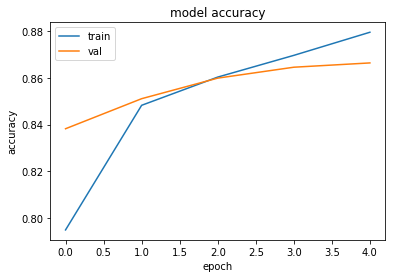

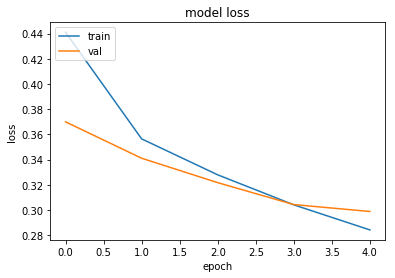

In [53]:
show_graphs(history4)

The accuracy is not bad but it's lower than the ones in part 1 due to a couple of reasons:


*   In part 1, the competency of the models for predecting the exact labels of the labelled comments is hidden behind the sheer size of the clean comments.
*   The number of labelled comments is really not big enough.
*   The labelling of these not-clean comments might not be very consistent since the dataset was crowd-sourced. (relevant discussion here: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/46131)



Anyway, let''s see the test set performance:

In [0]:
dirty_preds = (model4.predict(X_te2) > 0.5).astype(int)

In [55]:
dirty_preds

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [1, 1, 1, 0, 1, 0],
       [1, 1, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0]])

In [56]:
y_te2

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 1, 0],
       ...,
       [1, 1, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 0],
       [1, 0, 0, 0, 1, 0]], dtype=int64)

We use hamming loss instead of accuracy_score of scikit learn beacuse it is not suitable (as explained in part 1).

In [57]:
1 - hamming_loss(y_te2, dirty_preds)

0.8664225134926754

The test accuracy is very similar to the validation accuracy.

In [58]:
score, acc = model4.evaluate(X_te2, y_te2,
                            batch_size=32)
print('Test accuracy:', acc)

2594/2594 [==============================] - 11s 4ms/step
Test accuracy: 0.8664225034283599


Keras's evaluation is almost the same as our hamming loss evaluation.

# Combining the Predictions

Here we combine the test set predictions of the two stages, and see how they performe together.

The first stage predictions (classification) of the test set is preds_new, it's also appened to y_test2. The second stage predictions of the test set (only for the predicted-not-clean ones) is dirty_preds.

In [59]:
dirty_preds.shape

(2594, 6)

In [60]:
count = 0
for x in preds_new:
  if(x[0]==1):
    count+=1
count

29321

Let's construct a new data frame to hold the true values of the six original categories:

In [61]:
final_true = pd.DataFrame()
final_true = y_test2.copy()
final_true.drop(['clean', 'not_clean', 'preds'], axis=1, inplace=True)
final_true.reset_index(drop=True, inplace=True)
final_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31915 entries, 0 to 31914
Data columns (total 6 columns):
toxic            31915 non-null int64
severe_toxic     31915 non-null int64
obscene          31915 non-null int64
threat           31915 non-null int64
insult           31915 non-null int64
identity_hate    31915 non-null int64
dtypes: int64(6)
memory usage: 1.5 MB


Note that the numbers add up: 31915 (all test set) = 29321 (predcited clean) + 2594 (predicted not clean then classified for each label) 

We also create another frame for holding the combined predictions. For now, it will have the preds column (the predictions of the first stage).

In [62]:
final_preds = pd.DataFrame()
final_preds = y_test2.copy()
final_preds.drop(['clean', 'not_clean'], axis=1, inplace=True)
final_preds.reset_index(drop=True, inplace=True)
final_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31915 entries, 0 to 31914
Data columns (total 7 columns):
toxic            31915 non-null int64
severe_toxic     31915 non-null int64
obscene          31915 non-null int64
threat           31915 non-null int64
insult           31915 non-null int64
identity_hate    31915 non-null int64
preds            31915 non-null int64
dtypes: int64(7)
memory usage: 1.7 MB


The following loop walks over our final_preds frame row by row. If preds is 1 (i.e. predicted clean), all the labels are set to zero, if preds is 0 (i.e. predicted not-clean) the labels are set according to their coressponding predictions in the dirty_preds array (which, again, holds thhe predicted labels for those comments which were classified as not-clean).  

In [0]:
i = 0
j = 0
while i < 31915:
  if(final_preds.iloc[i].preds == 1):
    final_preds.iloc[i].toxic = 0
    final_preds.iloc[i].severe_toxic = 0
    final_preds.iloc[i].obscene = 0
    final_preds.iloc[i].threat = 0
    final_preds.iloc[i].insult = 0
    final_preds.iloc[i].identity_hate = 0
  else:
    final_preds.iloc[i].toxic = dirty_preds[j][0]
    final_preds.iloc[i].severe_toxic = dirty_preds[j][1]
    final_preds.iloc[i].obscene = dirty_preds[j][2]
    final_preds.iloc[i].threat = dirty_preds[j][3]
    final_preds.iloc[i].insult = dirty_preds[j][4]
    final_preds.iloc[i].identity_hate = dirty_preds[j][5]
    j+=1
  i+=1

drop the preds column:

In [0]:
final_preds.drop(['preds'], axis=1, inplace=True)

Finally, we calculate the precitions accuracy using hamming_loss: 

In [65]:
1 - hamming_loss(final_true.values, final_preds.values)

0.9832680557731475

This is about half a percent higher than the highest accuracy obtained in part 1 (using hamming loss).

# Verdict

Initially, our goal was to see if our approach will perform better than a normal LSTM. And it did (very slightly), but that is not really the important conclusion. Instead, we observed how the skewness (mostly clean comments) of the datasets can make accuracy scores deceptive. Although our stage 2 accuracy (it actually used to be about 70% before fine-tunning) is lower than the LSTMs in part 1, it only had a very minor effect on the overall accuracy of the combined predictions.

**Results round-up:**
*  Part 1:
  *  LSTM multi-label regression: 0.9574
  *  LSTM multi-label regression: 0.9598 (1-hamming: 0.9787)
* Part 2:
  *  First Stage (Nb_SVM clean/not clean classification): 0.8999
  *  First Stage (Logistic Regression clean/not clean classification): 0.8979
  *  First Stage (LSTM clean/not clean classification): 0.9648 
  *  Second Stage: 0.8664
  *  Combined: (1-hamming: 0.9833)